In [17]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random
Random.seed!(123)

include("relevant_slepian_alpha.jl")

get_quadrature_nodes_2D (generic function with 3 methods)

In [18]:
""" 
    interp2(z, xy, z0)

# Arguments
- `z::Vector` vector of z's
- `yx::Matrix` y, x coordinates at each of the z's
- `z0<:Number` level at which to interpolate z0

# Outputs
- zyx coordinates corresponding to level z0

"""
interp2(z::Vector, yx::Matrix, z0 = 0.0) = (yx[2,:] - yx[1,:])*(z0 - z[1])/(z[2] - z[1]) .+ yx[1,:]


# To get the closed curve at the level th, take the 100 points before and 100 points after 
# the crossing and interpolate each yx
"""
    interpcontour(z, z0, thph, N)

# Arguments
- `z::Vector` the two z-values between which the level z0 falls. 
- `z0<:Number` the z-level of the desired contour
- `thph::Matrix` the zyx coordinates (first N are at level z[1] second are at level z[2])
- `N::Int64` number of points for each contour
"""
function interpcontour(z, z0, thph, N)
    newcurve = map(i -> interp2(z, thph[[i, i + N],:], z0), 1:N) 
    return hcat(newcurve...)'
end


interpcontour

# Generate a random 3D surface

For 3D interpolation, some simplifying assumptions have been made:
- the 3D surface has been supplied as a set of contours in z-direction
- these contours are in sorted order (easy to generalize this)
- each contour has the same number of points, N

We will just stack a bunch of blobs.

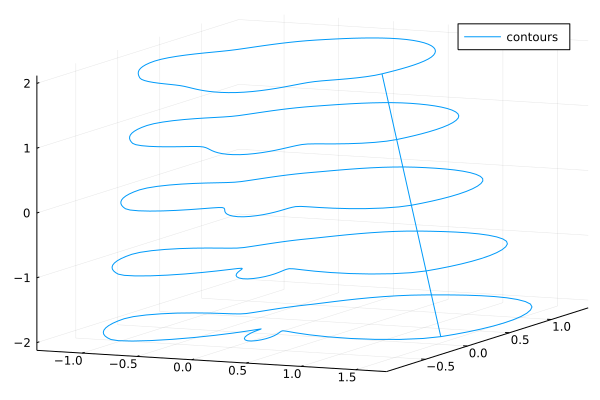

In [19]:
Nz = 5
x, y = blob(Nz,5)
N = 100
z = collect(-2:2)

Nx = length(x[1])
hcat(x[1], y[1])

# z, y, x is the order
thph = map(i -> hcat(ones(length(y[i]))*z[i], y[i], x[i]), 1:Nz)

# println(size(thph))
thph = vcat(thph...)
# This is necessary to close the curve
thph = vcat(thph, thph[1,:]')

p = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")

# Fill with quadrature nodes

## Get the quadrature nodes and scale to the range in z

In [20]:
Nqx = Nqy = 16
Nqz = 10

# Calculate blanks, z-axis GL points regardless of the data range
qz, wqz = FastGaussQuadrature.gausslegendre(Nqz)

mn, mx = (minimum(z), maximum(z))
# Scale the z-quadrature points to the min-max interval
th = qz*(abs(mx - mn)/2) .+ (mx + mn)/2;

# We need to find the two z's between which each quadrature point (th) lives
xmth = repeat(thph[:,1], 1, length(th)) .- repeat(th', length(thph[:,1]), 1)
dsx = diff(sign.(xmth), dims = 1)
col = findall(x -> (x == 2), dsx)
colf = map(c -> Tuple(c)[1], col)

10-element Array{Int64,1}:
 100
 100
 100
 200
 200
 300
 300
 400
 400
 400

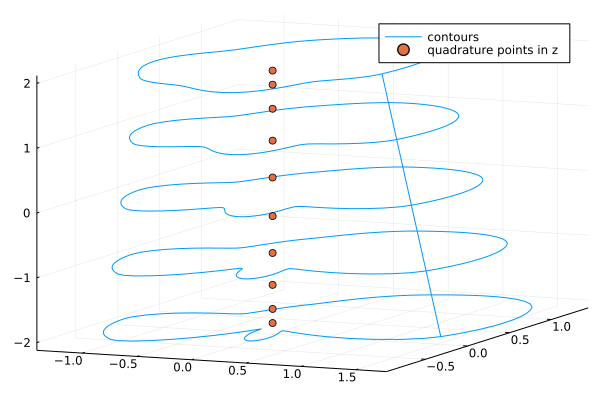

In [21]:
p1 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours")
scatter!(p1, zeros(Nqz), zeros(Nqz), th, label = "quadrature points in z")

## Fill the quadrature nodes at each level

Get the (x,y) values at each quadrature level z, and fill the closed curve of (x,y)'s with nodes. 

In [22]:
newcurve = map(i->interpcontour(thph[colf[i]:(colf[i]+1),1], th[i], thph[(colf[i]-N+1):(colf[i]+N),:], N), 1:length(th))
pkg = map(nc -> get_quadrature_nodes_2D(nc[:,3], nc[:,2], Nqx, Nqy), newcurve);
# QX, QY, w, Nrun = pkg[1]
# w[:, (Nrun+1):(Nrun+Nxint)] = wqx.*((b.-a)'/2)*wqy[yindex]

# Weights are in the third entry of the tuple
# pkg[i][3]

In [23]:
p2 = copy(p1)
for i = 1:length(th)
    scatter!(p2, newcurve[i][:,3],newcurve[i][:,2],newcurve[i][:,1], label = "z = $(round(1000*th[i])/1000)")
end
p2

LoadError: [91mMethodError: no method matching copy(::Plots.Plot{Plots.GRBackend})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  copy([91m::LinearAlgebra.Transpose{Bool,BitArray{2}}[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.5/LinearAlgebra/src/bitarray.jl:226[39m
[91m[0m  copy([91m::RecipesPipeline.DefaultsDict[39m) at /Users/charlottehaley/.julia/packages/RecipesPipeline/Bxu2O/src/utils.jl:47[39m
[91m[0m  copy([91m::Core.CodeInfo[39m) at expr.jl:63[39m
[91m[0m  ...[39m

To make sure everything is going right, we plot in 2D the quadrature nodes we are getting at each level.

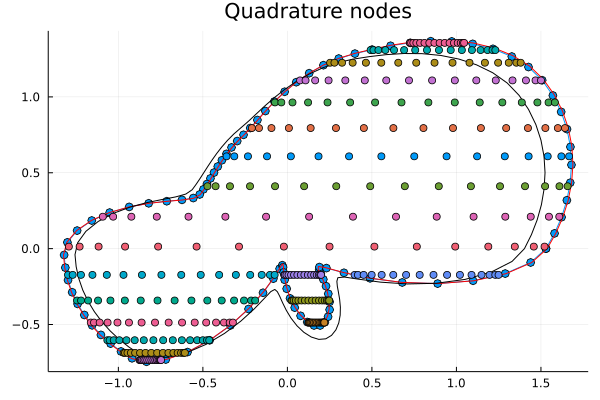

In [24]:
i = 1

q = plot(newcurve[i][:,3], newcurve[i][:,2], marker=:o, c = 1, label = "z = $(round(1000*th[i])/1000)")
plot!(q, thph[(colf[i]-N+1):(colf[i]), 3], thph[(colf[i]-N+1):(colf[i]), 2], label = "z = $(thph[colf[i]-N+1,1])", c = :red)
plot!(q, thph[(colf[i]+1):(colf[i]+N), 3], thph[(colf[i]+1):(colf[i]+N), 2], label = "z = $(thph[colf[i] + 1,1])", c = :black)

scatter!(q, pkg[i][1], pkg[i][2], legend = false, title = "Quadrature nodes")

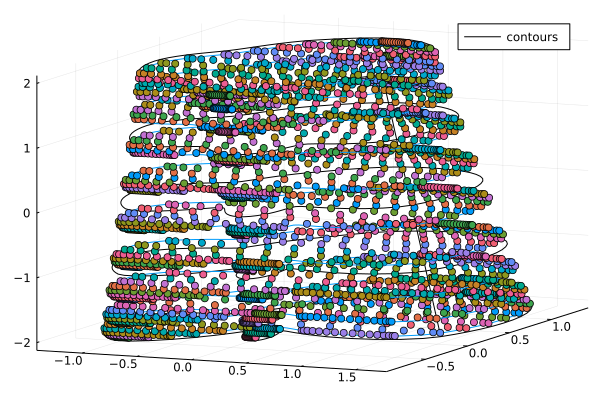

In [25]:
p3 = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
for i = 1:10
    plot!(p3, newcurve[i][:,3], newcurve[i][:,2], ones(size(newcurve[i][:,2]))*th[i], c = 1, label = "")
    scatter!(p3, pkg[i][1], pkg[i][2], ones(Nqx,Nqy+1)*th[i] , label = "")
end
p3

In [26]:
QX = mapreduce(p -> p[1][:], vcat, pkg)
QY = mapreduce(p -> p[2][:], vcat, pkg)
QZ = mapreduce(i -> ones(size(pkg[i][2][:]))*th[i], vcat, 1:length(pkg)); #kron(th, ones(Nqx, Nqy))[:]

println("$(size(QX)), $(size(QY)), $(size(QZ))")
#=
# Sanity check
plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
scatter!(QX, QY, QZ)
=#

(2896,), (2896,), (2896,)


In [27]:
# I think this is right 

# wts = mapreduce(p -> reshape(kron(wqz, p[3]), size(p[3])..., Nqz)[:], vcat, pkg)
wts = mapreduce(i -> ones(size(pkg[i][2][:]))*wqz[i], vcat, 1:length(pkg));

println("$(length(wqz)), $(length(wts))")

10, 2896


In [28]:
no    = map(i->(QX[i], QY[i], QZ[i]), 1:prod(size(QX)))
sqwt = sqrt.(wts);

size(no), size(sqwt)

((2896,), (2896,))

In [29]:
using FastGaussQuadrature, Plots, DelimitedFiles, Random, Slepians, KernelMatrices, KrylovKit, IterTools, FFTW
Random.seed!(123)

include("relevant_slepian_alpha.jl")

include("../src/RHMatrix.jl")

M  = 3
Kp = [4.0]
szs = int = (16, 16, 16)
prec = 1e-8
exact = false
lvl = 6
maxrank = 256

include("ext.jl")

customsleps_ext (generic function with 1 method)

In [30]:
ev = vec(collect(product([range(minimum(QX), maximum(QX), length = szs[1]), range(minimum(QY), maximum(QY), length = szs[2]), range(minimum(QZ), maximum(QZ), length = szs[3]) ]...)))
s, sl = customsleps_ext(M, Kp, szs, prec = prec, exact = exact, lvl = lvl, maxrank = maxrank, no = no,
        sqwt = sqwt, int = nothing, ev = ev);

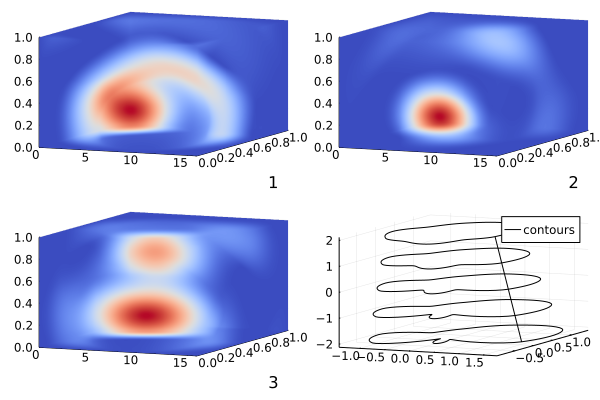

In [31]:
p1 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
p2 = Array{Plots.Plot{Plots.GRBackend},1}(undef, length(sl))
ran = 1:4
for i = ran
    p1[i] = heatmap( Float64.(sl[i]),
        c = :RdBu, clims = (-1.25, 1.25), ylabel = i) # this transpose is important
    #plot!(p1[i], x[1], y[1], legend = false, c = :black)

    SL = abs2.(fftshift(fft(sl[i])))
    p2[i] = heatmap(log10.(SL), ylabel = i)
end

psimple = plot(thph[:,3], thph[:,2], thph[:,1], label = "contours", c = :black);
plot(p1[1:3]..., psimple)

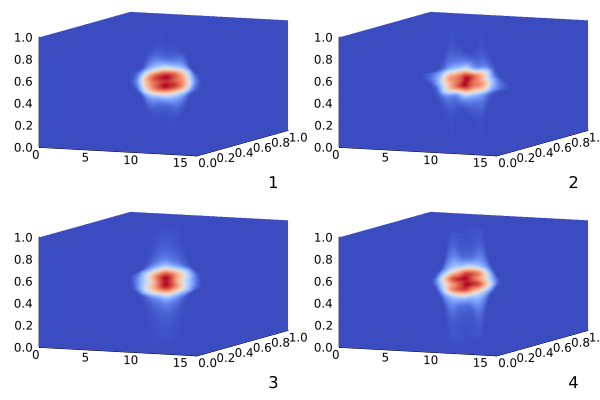

In [32]:
plot(p2[ran]...)